# PIE TRAINING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

In [ ]:
import os
os.chdir('/content/drive/Shareddrives/eecs442/PIE_PACK')
from pie_data import PIE
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import pickle
import cv2
import sys

import xml.etree.ElementTree as ET
import numpy as np

from os.path import join, abspath, isfile, isdir
from os import makedirs, listdir
from sklearn.model_selection import train_test_split, KFold
from matplotlib import pyplot as plt
import pylab
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
from torchsummary import summary
from tqdm import tqdm
import pandas as pd
import math
import random

In [ ]:
if torch.cuda.is_available():
    print("Using the GPU. You are good to go!")
    device = torch.device('cuda:0')
else:
    raise Exception("WARNING: Could not find GPU! Using CPU only. \
To enable GPU, please to go Edit > Notebook Settings > Hardware \
Accelerator and select GPU.")

Using the GPU. You are good to go!


In [ ]:
##############################################################################
# TODO: Adjust Sequence size and batch_size for loaders                      #
##############################################################################
SEQUENCE_SIZE = 20
BATCH_SIZE = 10
pie_path = '.'
imdb = PIE(data_path=pie_path, regen_database=True, include_set="1,2,5,6", frinterval=1, downsample=1600)

## Dataset

In [ ]:
class PedDataset(Dataset):
    def __init__(self, ped_personal_images_intention, data_range=(0, 1)):
        self.dataset = ped_personal_images_intention[data_range[0]:data_range[1]]
        for index in range(len(self.dataset)):
          self.dataset[index]=(self.dataset[index][0],self.dataset[index][1])
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_seq, label = self.dataset[index]
        seq_tensor = torch.stack(img_seq).cuda()
        label = int(label > 0.5)
        return torch.cuda.FloatTensor(seq_tensor), torch.tensor(label).cuda()




class PedDataset(Dataset):
    def __init__(self, ped_personal_images_intention, data_range=(0, 1)):
        self.dataset = ped_personal_images_intention[data_range[0]:data_range[1]]
        for index in range(len(self.dataset)):
          self.dataset[index]=(self.dataset[index][0],self.dataset[index][1])
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img_seq, label = self.dataset[index]
        seq_tensor = torch.stack(img_seq).cuda()
        label = int(label > 0.5)
        return torch.cuda.FloatTensor(seq_tensor), torch.tensor(label).cuda()

def get_ped_images_and_intention_v_colab(sequence_size=10, shuffle=True):
    ped_personal_intention_prob = pd.read_csv("ped_personal_intention_prob.csv")
    ped_personal_images_intention = []
    start = False
    for root, dirs, files in os.walk(imdb._input_path):
        print(root,len(ped_personal_images_intention))
        if start:
            temp_dir = []
            index_file = 0
            sequence_index = 0
            num_files = len(os.listdir(root))
            if num_files < sequence_size:
                continue
            files[:] = [int(float(x[:-4])) for x in files]
            index_file = sorted(files)[0]
            while sequence_index <sequence_size:
                temp_dir.append((torch.from_numpy(cv2.imread(join(root, str(index_file)+".png")).astype("f").transpose(2, 0, 1) / 128.0 - 1.0)))
                index_file += 2*int(math.floor(num_files / sequence_size))
                sequence_index += 1                    
            # print(ped_personal_intention_prob[root[8:]])
            ped_personal_images_intention.append((temp_dir, float(ped_personal_intention_prob[root[8:]])))
        else:
            start = True
        
    num_available_peds = len(ped_personal_images_intention)
    print(num_available_peds)
    if shuffle:
        random.shuffle(ped_personal_images_intention)
    return ped_personal_images_intention, num_available_peds

ped_personal_images_intention, num_available_peds = get_ped_images_and_intention_v_colab(sequence_size=SEQUENCE_SIZE, shuffle=True)
train_data = PedDataset(ped_personal_images_intention, data_range=(0, 200))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
#TODO: Checkout the shuffle option for the DataLoader function
val_data = PedDataset(ped_personal_images_intention, data_range=(200, 360))
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_data = PedDataset(ped_personal_images_intention, data_range=(360, 400))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
# test_data.__getitem__(0)

./input 0
./input/5_2_1750 0
./input/5_2_1751 1
./input/5_2_1752 2
./input/5_1_1747 3
./input/5_1_1748 4
./input/5_1_1749 4
./input/5_1_1746 5
./input/5_1_1744 6
./input/5_1_1742 7
./input/5_1_1745 8
./input/5_1_1740 9
./input/5_1_1739 9
./input/5_1_1741 9
./input/2_3_215 10
./input/5_1_1731 11
./input/2_3_217 12
./input/5_1_1732 13
./input/2_3_216 14
./input/2_3_214 15
./input/5_1_1733 16
./input/2_3_212 17
./input/2_3_211 18
./input/2_3_213 19
./input/2_3_207 20
./input/2_3_205 21
./input/2_3_208 22
./input/2_3_210 23
./input/2_3_206 24
./input/2_3_204 25
./input/2_3_209 26
./input/2_3_203 27
./input/2_3_201 28
./input/2_3_202 29
./input/2_3_197 30
./input/2_3_198 31
./input/2_3_194 32
./input/2_3_200 33
./input/2_3_195 34
./input/2_3_199 35
./input/2_3_196 36
./input/2_2_191 37
./input/2_2_193 38
./input/2_2_192 39
./input/2_2_186 40
./input/2_2_185 41
./input/2_2_190 42
./input/2_2_188 43
./input/2_2_187 44
./input/2_2_184 45
./input/2_2_189 46
./input/2_2_183 47
./input/2_2_182 48

## Model

In [ ]:
vgg = models.vgg19().features.cuda()
input_dim = 128
summary(vgg, (3, input_dim, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [ ]:
class nnModel(nn.Module):

    def __init__(self, input_size, hidden_size, cnn_output_size=512*4*4):
        """
        Initialize NN architecture.

        Hyperparameters
        ----------
        input_dim: int
            Input size in LSTM.
        hidden_dim: int
            Hidden size in LSTM.
        """

        super(nnModel, self).__init__()

        self.input_size = cnn_output_size
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTMCell(input_size=self.input_size, hidden_size=self.hidden_size).cuda()
        ##############################################################################
        # TODO: Adjust CNN Model                                                     #
        ##############################################################################
        self.cnn = models.vgg19(pretrained=True).features.cuda()
        ##############################################################################
        # TODO: Adjust CNN output size base on the summary function above            #
        ##############################################################################
        self.cnn_output_size = cnn_output_size
        self.fc_cnn_lstm = nn.Linear(self.cnn_output_size, self.input_size).cuda()
        self.fc_lstm_output = nn.Linear(self.hidden_size, 2).cuda()


    def init_weights(self):
        """Initializing lstm weights."""
        """TODO: Adjust initialization."""
        nn.init.xavier_uniform_(self.lstm1.weight_ih, gain=1.0).cuda()
        nn.init.xavier_uniform_(self.lstm1.weight_hh, gain=1.0).cuda()
        nn.init.constant_(self.lstm1.bias_ih, 0.0).cuda()
        nn.init.constant_(self.lstm1.bias_hh, 0.0).cuda()

    def init_hidden(self, N):
        """Initializing hidden states and cell states."""
        h_0 = torch.zeros(N, self.hidden_size).cuda()
        c_0 = torch.zeros(N, self.hidden_size).cuda()
        return h_0, c_0

    def forward(self, img_sequence):
        N,T,d,x,y = img_sequence.shape  # N is batchsize T is timestep, d = 3
        #print("img_sequence",img_sequence.size())
        # declaring the initial hidden states and cell states
        h_t, c_t = self.init_hidden(N)

        for i in range(T):
            img = img_sequence[:,i,:,:,:]   #N*Cin*Hin*Win
            #print(img.shape)
            img_features = self.cnn(img).view(-1,self.cnn_output_size)    #N*Cout*Hout*Wout
            i_t = self.fc_cnn_lstm(img_features)
            h_t,c_t = self.lstm1(i_t,(h_t,c_t))
            #h_t,c_t = self.lstm1(img_features,(h_t,c_t))
            
        output = self.fc_lstm_output(h_t)

        return output

        # NOTE: Optional bbox sequence data
        # input_size2 = hidden_size1
        # hidden_size2 = hidden_size2
        # lstm2 = nn.LSTMCell(input_size=input_size2,hidden_size=hidden_size2)
        # h_t=c_t = torch.zeros(N, hidden_size2)#
        # for i in range(T):
        # input = (h + bbox_sequence[:,-i,:,:,:]).view(N,-1)
        # h_t,c_t = lstm(input,(h_t,c_t))


##############################################################################
# TODO: Adjust Input_size and hidden_size here                               #
##############################################################################
model = nnModel(32 , 128).cuda()#.to(device)
criterion = nn.CrossEntropyLoss().cuda() # Specify the loss layer
print('Your network:')
print(model)
#print(summary(model, (BATCH_SIZE,SEQUENCE_SIZE,3,128,128))) # visualize your model 

Your network:
nnModel(
  (lstm1): LSTMCell(8192, 128)
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 

## Training

In [ ]:
lr = 1e-6
weight_decay = 5e-3
num_epoch = 10
optimizer = optim.Adam(model.parameters(), lr=lr,
                       weight_decay=weight_decay)


In [ ]:
# %%time
def train(model,trainloader, valloader, num_epoch = 10): # Train the model
  print("Srain(model, tart training...")
  trn_loss_hist = []
  trn_acc_hist = []
  val_acc_hist = []
  model.train() # Set the model to training mode
  for i in range(num_epoch):
    running_loss = []
    print('-----------------Epoch = %d-----------------' % (i+1))
    for batch, label in tqdm(trainloader):
      batch = batch.to(device)
      label = label.to(device)
      #print("batch",batch.size())
      optimizer.zero_grad() # Clear gradients from the previous iteration
      pred = model(batch) # This will call Network.forward() that you implement
      loss = criterion(pred, label) # Calculate the loss
      running_loss.append(loss.item())
      loss.backward() # Backprop gradients to all tensors in the network
      optimizer.step() # Update trainable weights
    print("\n Epoch {} loss:{}".format(i+1,np.mean(running_loss)))

    # Keep track of training loss, accuracy, and validation loss
    trn_loss_hist.append(np.mean(running_loss))
    trn_acc_hist.append(evaluate(model, trainloader))
    print("\n Evaluate on validation set...")
    val_acc_hist.append(evaluate(model, valloader))
  print("Done!")
  return trn_loss_hist, trn_acc_hist, val_acc_hist

def evaluate(model, loader): # Evaluate accuracy on validation / test set
  model.eval() # Set the model to evaluation mode
  correct = 0
  with torch.no_grad(): # Do not calculate grident to speed up computation
    for batch, label in tqdm(loader):
      batch = batch.to(device)
      label = label.to(device)
      pred = model(batch)
      correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("\n Evaluation accuracy: {}".format(acc))
    return acc
    
trn_loss_hist, trn_acc_hist, val_acc_hist = train(model, train_loader, 
                                                  val_loader, num_epoch)

##############################################################################
# TODO: Note down the evaluation accuracy on test set                        #
##############################################################################
print("\n Evaluate on test set")
evaluate(model, test_loader);



  0%|          | 0/20 [00:00<?, ?it/s]

Srain(model, tart training...
-----------------Epoch = 1-----------------




  5%|▌         | 1/20 [00:01<00:29,  1.54s/it]

 10%|█         | 2/20 [00:03<00:28,  1.58s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.68s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

 40%|████      | 8/20 [00:13<00:20,  1.70s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.71s/it]

 50%|█████     | 10/20 [00:16<00:17,  1.72s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.73s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.74s/it]

 65%|██████▌   | 13/20 [00:22<00:12,  1.75s/it]

 70%|███████   | 14/20 [00:24<00:10,  1.76s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.76s/it]

 80%|████████  | 16/20 [00:27<00:07,  1.77s/it]

 85%|████████▌ | 17/20 [00:29<00:05,  1.77s/it]

 90%|█████████ | 18/20 [00:31<00:03,  1.77s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.76s/it]

100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


  0%|          | 0/20 [00:


 Epoch 1 loss:0.6453452706336975




  5%|▌         | 1/20 [00:00<00:15,  1.25it/s]

 10%|█         | 2/20 [00:01<00:13,  1.35it/s]

 15%|█▌        | 3/20 [00:02<00:11,  1.42it/s]

 20%|██        | 4/20 [00:02<00:10,  1.48it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

 30%|███       | 6/20 [00:03<00:08,  1.57it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

 40%|████      | 8/20 [00:05<00:07,  1.61it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.64it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.64it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.66it/s]

 65%|██████▌   | 13/20 [00:08<00:04,  1.66it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.66it/s]

 75%|███████▌  | 15/20 [00:09<00:03,  1.66it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.67it/s]

 90%|█████████ | 18/20 [00:11<00:01,  1.67it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.745

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.71it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.70it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.71it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.70it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.70it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.70it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.70it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.70it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.70it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.70it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.69it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.69it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.69it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.70it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.70it/s]

100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 2-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.49s/it]

 10%|█         | 2/20 [00:03<00:27,  1.55s/it]

 15%|█▌        | 3/20 [00:04<00:26,  1.59s/it]

 20%|██        | 4/20 [00:06<00:25,  1.61s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.63s/it]

 30%|███       | 6/20 [00:09<00:23,  1.65s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.66s/it]

 40%|████      | 8/20 [00:13<00:19,  1.66s/it]

 45%|████▌     | 9/20 [00:14<00:18,  1.67s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.67s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.68s/it]

 60%|██████    | 12/20 [00:19<00:13,  1.68s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.68s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.68s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.68s/it]

 80%|████████  | 16/20 [00:26<00:06,  1.68s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.68s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.69s/it]

 95%|█████████▌| 19/20 [00:31<00:01,  1.69s/it]

100%|██████████| 20/20 [00:33<00:00,  1.68s/it]


  0%|          | 0/20 [00:


 Epoch 2 loss:0.5451071411371231




  5%|▌         | 1/20 [00:00<00:14,  1.29it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.64it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.745

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.68it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.68it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.67it/s]

 31%|███▏      | 5/16 [00:03<00:06,  1.67it/s]

 38%|███▊      | 6/16 [00:03<00:06,  1.66it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.66it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.66it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.66it/s]

 62%|██████▎   | 10/16 [00:06<00:03,  1.66it/s]

 69%|██████▉   | 11/16 [00:06<00:03,  1.66it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.66it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.66it/s]

 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]

100%|██████████| 16/16 [00:09<00:00,  1.66it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 3-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.68s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

 40%|████      | 8/20 [00:13<00:20,  1.70s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

 50%|█████     | 10/20 [00:16<00:17,  1.70s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:22<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


  0%|          | 0/20 [00:


 Epoch 3 loss:0.4906370177865028




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.61it/s]

 35%|███▌      | 7/20 [00:04<00:07,  1.63it/s]

 40%|████      | 8/20 [00:04<00:07,  1.65it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

 50%|█████     | 10/20 [00:06<00:05,  1.67it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.68it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.68it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.69it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.69it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.69it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.69it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.69it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.70it/s]

100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.755

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.71it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.70it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.70it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.70it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.70it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.70it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.70it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.70it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.69it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.69it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.69it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.69it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.70it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.69it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.69it/s]

100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 4-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

 20%|██        | 4/20 [00:06<00:26,  1.63s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.65s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.69s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


  0%|          | 0/20 [00:


 Epoch 4 loss:0.44371253103017805




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.64it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.66it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.66it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.78

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.71it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.70it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.69it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.68it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.68it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.68it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.68it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.68it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.68it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.67it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.67it/s]

100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 5-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.70s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:22<00:11,  1.71s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.71s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.71s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.71s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.71s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.71s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.71s/it]

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


  0%|          | 0/20 [00:


 Epoch 5 loss:0.40224459022283554




  5%|▌         | 1/20 [00:00<00:14,  1.29it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.46it/s]

 20%|██        | 4/20 [00:02<00:10,  1.52it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.56it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.63it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.66it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.66it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.68it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.67it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.83

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.68it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.68it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.68it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.68it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.68it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.67it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.67it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.67it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.67it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.67it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.67it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.68it/s]

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 6-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.70s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.71s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.71s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


  0%|          | 0/20 [00:


 Epoch 6 loss:0.36286781579256056




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:07,  1.63it/s]

 40%|████      | 8/20 [00:04<00:07,  1.65it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.68it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.885

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.71it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.70it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.70it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.69it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.69it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.69it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.69it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.68it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.68it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.68it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.68it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.68it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.68it/s]

100%|██████████| 16/16 [00:09<00:00,  1.68it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 7-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.52s/it]

 10%|█         | 2/20 [00:03<00:28,  1.58s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.62s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.69s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


  0%|          | 0/20 [00:


 Epoch 7 loss:0.326704990118742




  5%|▌         | 1/20 [00:00<00:14,  1.32it/s]

 10%|█         | 2/20 [00:01<00:12,  1.41it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.48it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.58it/s]

 30%|███       | 6/20 [00:03<00:08,  1.61it/s]

 35%|███▌      | 7/20 [00:04<00:07,  1.63it/s]

 40%|████      | 8/20 [00:04<00:07,  1.65it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.68it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.68it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.68it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.68it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.69it/s]

100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.91

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.69it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.68it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.69it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.69it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.68it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.68it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.67it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.67it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.68it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.66it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.66it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.67it/s]

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 8-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.50s/it]

 10%|█         | 2/20 [00:03<00:28,  1.56s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.69s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.69s/it]


  0%|          | 0/20 [00:


 Epoch 8 loss:0.2952172182500362




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.63it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.66it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.68it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.68it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.935

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.68it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.68it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.68it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.68it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.68it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.68it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.68it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.68it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.68it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.68it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.67it/s]

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 9-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

 50%|█████     | 10/20 [00:16<00:16,  1.70s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.70s/it]

 65%|██████▌   | 13/20 [00:21<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.70s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.70s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


  0%|          | 0/20 [00:


 Epoch 9 loss:0.2680384419858456




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.53it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.64it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.67it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.67it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.965

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.69it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.68it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.68it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.68it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.68it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.68it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.67it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.66it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.67it/s]

 69%|██████▉   | 11/16 [00:06<00:03,  1.67it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.67it/s]

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
-----------------Epoch = 10-----------------




  5%|▌         | 1/20 [00:01<00:28,  1.51s/it]

 10%|█         | 2/20 [00:03<00:28,  1.57s/it]

 15%|█▌        | 3/20 [00:04<00:27,  1.61s/it]

 20%|██        | 4/20 [00:06<00:26,  1.64s/it]

 25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

 30%|███       | 6/20 [00:10<00:23,  1.67s/it]

 35%|███▌      | 7/20 [00:11<00:21,  1.68s/it]

 40%|████      | 8/20 [00:13<00:20,  1.69s/it]

 45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

 50%|█████     | 10/20 [00:16<00:17,  1.70s/it]

 55%|█████▌    | 11/20 [00:18<00:15,  1.70s/it]

 60%|██████    | 12/20 [00:20<00:13,  1.71s/it]

 65%|██████▌   | 13/20 [00:22<00:11,  1.70s/it]

 70%|███████   | 14/20 [00:23<00:10,  1.71s/it]

 75%|███████▌  | 15/20 [00:25<00:08,  1.71s/it]

 80%|████████  | 16/20 [00:27<00:06,  1.71s/it]

 85%|████████▌ | 17/20 [00:28<00:05,  1.70s/it]

 90%|█████████ | 18/20 [00:30<00:03,  1.70s/it]

 95%|█████████▌| 19/20 [00:32<00:01,  1.70s/it]

100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


  0%|          | 0/20 [00:


 Epoch 10 loss:0.243914458155632




  5%|▌         | 1/20 [00:00<00:14,  1.30it/s]

 10%|█         | 2/20 [00:01<00:12,  1.39it/s]

 15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

 20%|██        | 4/20 [00:02<00:10,  1.52it/s]

 25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

 30%|███       | 6/20 [00:03<00:08,  1.60it/s]

 35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

 40%|████      | 8/20 [00:04<00:07,  1.63it/s]

 45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

 50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

 55%|█████▌    | 11/20 [00:06<00:05,  1.66it/s]

 60%|██████    | 12/20 [00:07<00:04,  1.67it/s]

 65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

 70%|███████   | 14/20 [00:08<00:03,  1.67it/s]

 75%|███████▌  | 15/20 [00:09<00:02,  1.68it/s]

 80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

 85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

 90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

 95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


  0%|          | 0/16 [00:


 Evaluation accuracy: 0.97

 Evaluate on validation set...




  6%|▋         | 1/16 [00:00<00:08,  1.71it/s]

 12%|█▎        | 2/16 [00:01<00:08,  1.69it/s]

 19%|█▉        | 3/16 [00:01<00:07,  1.69it/s]

 25%|██▌       | 4/16 [00:02<00:07,  1.68it/s]

 31%|███▏      | 5/16 [00:02<00:06,  1.68it/s]

 38%|███▊      | 6/16 [00:03<00:05,  1.68it/s]

 44%|████▍     | 7/16 [00:04<00:05,  1.68it/s]

 50%|█████     | 8/16 [00:04<00:04,  1.68it/s]

 56%|█████▋    | 9/16 [00:05<00:04,  1.67it/s]

 62%|██████▎   | 10/16 [00:05<00:03,  1.67it/s]

 69%|██████▉   | 11/16 [00:06<00:02,  1.67it/s]

 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]

 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]

 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]

 94%|█████████▍| 15/16 [00:08<00:00,  1.68it/s]

100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


 Evaluation accuracy: 0.75
Done!

 Evaluate on test set




 25%|██▌       | 1/4 [00:00<00:01,  1.70it/s]

 50%|█████     | 2/4 [00:01<00:01,  1.69it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  1.68it/s]

100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


 Evaluation accuracy: 0.65


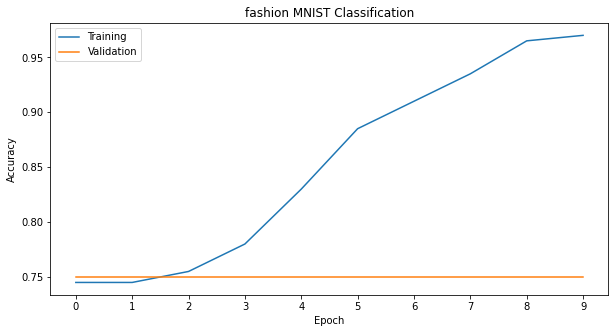

In [ ]:
##############################################################################
# TODO: Submit the accuracy plot                                             #
##############################################################################
# visualize the training / validation accuracies
x = np.arange(num_epoch)
# train/val accuracies for MiniVGG
plt.figure()
plt.plot(x, trn_acc_hist)
plt.plot(x, val_acc_hist)
plt.legend(['Training', 'Validation'])
plt.xticks(x)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('fashion MNIST Classification')
plt.gcf().set_size_inches(10, 5)
plt.show()